In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.resample_roms import resample
from features.grid_ttide import NDinterp
from features.log_progress import log_progress

In [2]:
wb_path = os.path.join(os.environ.get('extdir'),'adusumilli','basal_melt_rates_2011-2017.nc')
wb = xr.open_dataset(wb_path)

In [4]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grid = xr.open_dataset(file_path)

In [58]:
wb.w_b.lon

<xarray.DataArray 'lon' (lon: 421)>
array([   0.      ,    0.857143,    1.714286, ...,  358.285714,  359.142857,
        360.      ])
Coordinates:
  * lon      (lon) float64 0.0 0.8571 1.714 2.571 3.429 4.286 5.143 6.0 ...
Attributes:
    long_name:     longitude
    actual_range:  [   0.  360.]

array([   0.  ,    0.05,    0.1 , ...,  359.9 ,  359.95,  360.  ])

In [72]:
lat = np.linspace(-86,-65,421)
lon = np.linspace(0,360,7201)
lon[lon>180]-=360
lon_s,lat_s = np.meshgrid(lon,lat)

wb_filled = NDinterp(wb.w_b.values)

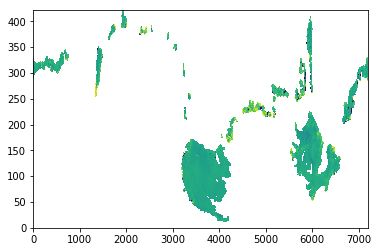

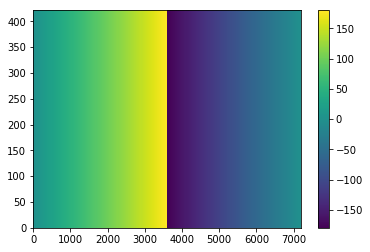

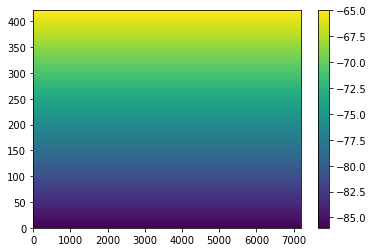

In [109]:
plt.close()
plt.pcolormesh(wb.w_b)
plt.show()
plt.pcolormesh(lon_s)
plt.colorbar()
plt.show()
plt.pcolormesh(lat_s)
plt.colorbar()
plt.show()

In [111]:
w_b_resampled = resample(lon_s,lat_s,grid.lon_rho.values,grid.lat_rho.values,wb.w_b.values)

In [113]:
wb_res = w_b_resampled.data
wb_res[w_b_resampled.mask] = np.nan

In [114]:
wb_res = NDinterp(wb_res)

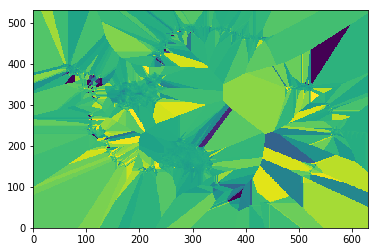

In [115]:
plt.close()
plt.pcolormesh(wb_res)
plt.show()

In [116]:
wb_res *= 917/1025
wb_res *= 1/(365*24*3600)

In [158]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_nudge.nc')
nudge = xr.open_dataset(file_path)

In [159]:
nudge.sst_time

<xarray.DataArray 'sst_time' (sst_time: 12)>
array([ 1313999971200000,  3942000000000000,  6570000028800000,
        9197999971200000, 11826000000000000, 14454000028800000,
       17081999971200000, 19710000000000000, 22338000028800000,
       24965999971200000, 27594000000000000, 30222000028800000], dtype='timedelta64[ns]')
Coordinates:
  * sst_time  (sst_time) timedelta64[ns] 15 days 04:59:59.971200 ...
Attributes:
    long_name:     time since initialization
    cycle_length:  365.0

In [160]:
nudge['wb'] = xr.DataArray(np.tile(wb_res,(12,1,1)),dims=['sst_time','eta_rho','xi_rho'],attrs=wb.attrs,coords={'sst_time':nudge.sst_time})

In [162]:
nudge.wb.attrs['units']='m. of ice per year (ice density 917 kg m^-3)'
nudge.wb.attrs['sign']='+ = melting; - = freezing'

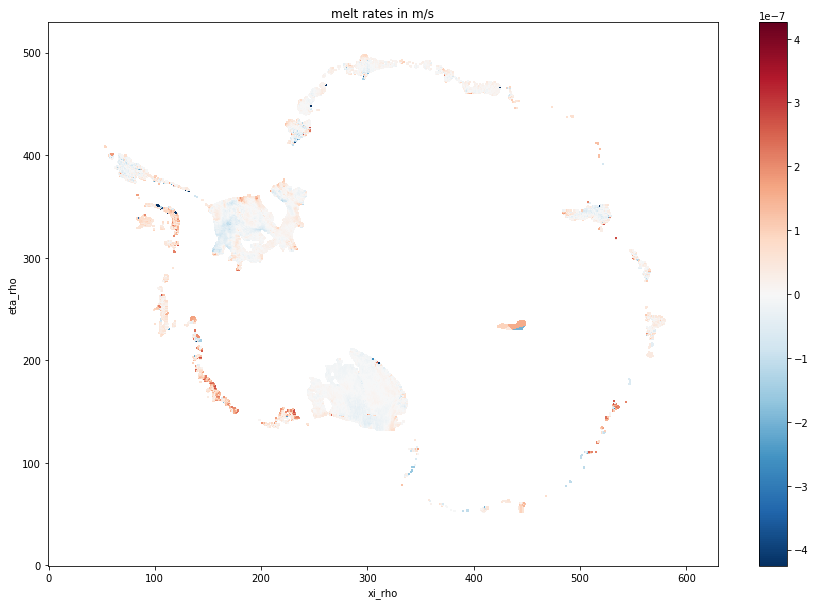

In [163]:
plt.close()
nudge.wb[-1].where(((grid.mask_rho==1)&(grid.zice<0))).plot(size=10)
plt.title('melt rates in m/s')
plt.show()

In [164]:
out_path = os.path.join(file_path,os.pardir,'waom10_small_nudge_wb.nc')
nudge.to_netcdf(out_path)

In [146]:
nudge.dQdSST

<xarray.DataArray 'dQdSST' (sst_time: 12, eta_rho: 530, xi_rho: 630)>
[4006800 values with dtype=float64]
Coordinates:
  * sst_time  (sst_time) timedelta64[ns] 15 days 04:59:59.971200 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  surface net heat flux sensitivity to SST
    units:      watt meter-2 Celsius-1

In [152]:
nudge.sst_time

OrderedDict()